# LLaMA 3 8B Text Classification Without QLoRA 

In [1]:
import pandas as pd
import torch
import json
import wandb
from transformers import BitsAndBytesConfig, AutoModelForSequenceClassification, AutoTokenizer
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from datasets import DatasetDict
import datetime

In [2]:
config_data = json.load(open('../config.json'))
HF_TOKEN = config_data['HF_TOKEN']
WANDB_TOKEN = config_data['WANDB_TOKEN']

wandb.login(key=WANDB_TOKEN)

run = wandb.init(
    project='wz_experimental',
    config={"model_name": "Meta-Llama-3-8B"}
)

wandb: Currently logged in as: kawishbit (kawishbit-org). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\kawis\_netrc


In [3]:
id_to_label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
label_to_id_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
cefr_levels = ["A1", "A2", "B1", "B2", "C1", "C2"]

In [4]:
train = pd.read_csv('../datasets/quotes/quotes_train.csv')
test = pd.read_csv('../datasets/quotes/quotes_test.csv')
validation = train.sample(2091, random_state=42)
train = train.drop(validation.index)

train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
validation = validation.sample(frac=1).reset_index(drop=True)

In [5]:
train.head()

,text,label,level
0,if there is a soul then it is a mistake to th...,1,A2
1,psychological trauma is an affliction of the p...,3,B2
2,even the ugliest swan is still more beautiful ...,2,B1
3,a writer looks at an issue and asks what if t...,1,A2
4,conflict forces us to be fully present because...,3,B2


In [6]:
test.head()

,text,label,level
0,youre the optimist all the way through preten...,1,A2
1,the truth is most of the genuinely tragic epi...,1,A2
2,i mean the shoe there is a music to it ther...,0,A1
3,law and order are the medicine of the politic ...,1,A2
4,presidents have absolutely gone against the wi...,2,B1


In [7]:
validation.head()

,text,label,level
0,he is really not so ugly after all provided ...,0,A1
1,solitude a time for memories a time to dream...,3,B2
2,knowing your real life purpose makes you clear...,1,A2
3,if you can persist your originality at every s...,3,B2
4,be true to yourself be positive always keep ...,2,B1


In [8]:
train.label.value_counts(normalize=True)

label
0    0.320707
1    0.278053
2    0.178053
3    0.176255
4    0.045257
5    0.001674
Name: proportion, dtype: float64

In [9]:
class_weights=(1/train.label.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights

tensor([0.0049, 0.0056, 0.0088, 0.0089, 0.0347, 0.9371])

In [10]:
model_name = "meta-llama/Meta-Llama-3-8B"

In [11]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = 'nf4',
    bnb_4bit_use_double_quant = True,
    bnb_4bit_compute_dtype = torch.bfloat16
)

In [12]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.0,
    target_modules = ['down_proj', 'gate_proj', 'o_proj', 'v_proj', 'up_proj', 'q_proj', 'k_proj'],
    bias = 'none',
    task_type = 'SEQ_CLS'
)

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    num_labels=6,
    device_map=None,
    resume_download=None,
    low_cpu_mem_usage=True
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model = prepare_model_for_kbit_training(model)

In [15]:
model = get_peft_model(model, lora_config)

In [16]:
model.gradient_checkpointing_enable()

In [17]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    resume_download=None,
    add_prefix_space=True
)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

In [19]:
sentences = test.text.tolist()
sentences[0:2]

['youre the optimist all the way through  pretending to be a pessimist on the inside  because you can act like it hurts less if you say you knew all along it was going to go down like that',
 'the truth is  most of the genuinely tragic episodes of lost food are things that are somewhat outside the reach of the home cook  even a home cook like me who has been known to overreach from time to time']

In [20]:
print(f'Started prediction at {datetime.datetime.now()}')
sentences = test.text.tolist()

batch_size = 32

all_outputs = []

for i in range(0, len(sentences), batch_size):
    batch_sentences = sentences[i:i + batch_size]

    inputs = tokenizer(batch_sentences, return_tensors="pt",
                       padding=True, truncation=True, max_length=512)

    inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        all_outputs.append(outputs['logits'])

Started prediction at 2024-08-18 15:48:36.254586


C:\Users\kawis\anaconda3\Lib\site-packages\transformers\models\llama\modeling_llama.py:671: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [21]:
final_outputs = torch.cat(all_outputs, dim=0)
final_outputs

tensor([[-0.9528,  1.1304, -9.7706,  0.6373,  1.5618,  2.9230],
        [-0.3459,  1.8187, -3.2235, -0.3816,  0.2048,  4.7665],
        [ 0.6283,  4.2588, -4.0008,  0.4230, -6.1034,  1.5827],
        ...,
        [ 1.1090, -2.7579, -2.5833, -0.4906,  2.2061,  1.3668],
        [ 0.1268, -0.5924, -4.8288,  0.0187, -2.1031,  1.4866],
        [-0.2208,  0.2844, -4.5785, -2.8347,  2.2680,  1.4909]],
       device='cuda:0')

In [22]:
final_outputs.argmax(axis=1)

tensor([5, 5, 1,  ..., 4, 5, 4], device='cuda:0')

In [23]:
test['predictions'] = final_outputs.argmax(axis=1).cpu().numpy()
test['predictions']

0       5
1       5
2       1
3       4
4       5
       ..
2687    4
2688    5
2689    4
2690    5
2691    4
Name: predictions, Length: 2692, dtype: int64

In [24]:
test['predictions'].value_counts()

predictions
5    961
4    622
1    489
0    438
3    176
2      6
Name: count, dtype: int64

In [25]:
test['predictions']=test['predictions'].apply(lambda x: id_to_label_mapping[x])
test['predictions']

0       C2
1       C2
2       A2
3       C1
4       C2
        ..
2687    C1
2688    C2
2689    C1
2690    C2
2691    C1
Name: predictions, Length: 2692, dtype: object

Accuracy: 0.147
Accuracy for label A1: 0.190
Accuracy for label A2: 0.183
Accuracy for label B1: 0.005
Accuracy for label B2: 0.075
Accuracy for label C1: 0.380
Accuracy for label C2: 0.200

Classification Report:
              precision    recall  f1-score   support

          A1       0.37      0.19      0.25       853
          A2       0.28      0.18      0.22       753
          B1       0.33      0.00      0.01       442
          B2       0.21      0.08      0.11       492
          C1       0.09      0.38      0.14       142
          C2       0.00      0.20      0.00        10

    accuracy                           0.15      2692
   macro avg       0.21      0.17      0.12      2692
weighted avg       0.29      0.15      0.17      2692


Confusion Matrix:
[[162 150   0  73 133 335]
 [103 138   0  44 132 336]
 [ 61  87   2  14 128 150]
 [ 82  86   2  37 168 117]
 [ 29  28   2   8  54  21]
 [  1   0   0   0   7   2]]


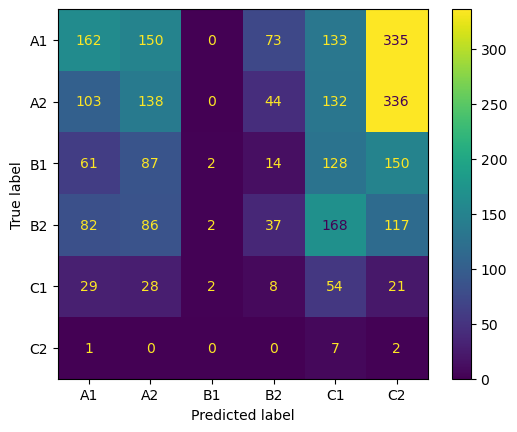

In [26]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

y_pred = test['predictions']

y_true = test['level']

def map_func(x):
    return label_to_id_mapping.get(x, -1)

y_true_mapped = np.vectorize(map_func)(y_true)
y_pred_mapped = np.vectorize(map_func)(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
print(f'Accuracy: {accuracy:.3f}')

# Generate accuracy report
unique_labels = set(y_true_mapped)  # Get unique labels

for label in unique_labels:
    label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
    label_y_true = [y_true_mapped[i] for i in label_indices]
    label_y_pred = [y_pred_mapped[i] for i in label_indices]
    label_accuracy = accuracy_score(label_y_true, label_y_pred)
    print(f'Accuracy for label {cefr_levels[label]}: {label_accuracy:.3f}')

class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))))
class_report_dict = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))), output_dict=True)
print('\nClassification Report:')
print(class_report)
table_data = []

for key, value in class_report_dict.items():
    if isinstance(value, dict):
        table_data.append([
            key,
            value.get("precision", 0),
            value.get("recall", 0),
            value.get("f1-score", 0),
            value.get("support", 0)
        ])
    else:
        # For accuracy, add precision and recall as 0
        table_data.append([
            key,
            0,
            0,
            value,
            class_report_dict["weighted avg"]["support"]
        ])

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(cefr_levels))))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=cefr_levels)
disp.plot()


print('\nConfusion Matrix:')
print(conf_matrix)

wandb.log({
    "Class Proportions": wandb.sklearn.plot_class_proportions(train['level'], test['level'], cefr_levels),
    "Confusion Matrix": plt,
    "Classification Report": wandb.Table(data=table_data, columns=['Class/Metric', 'Precision', 'Recall', 'F1-score', 'Support'])
})

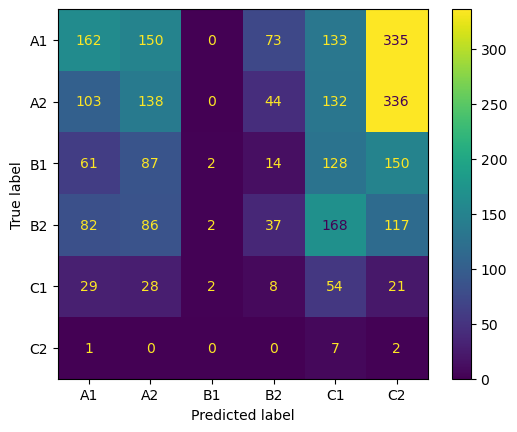

In [27]:
disp.plot()
plt.show()

In [28]:
print(f'Ended prediction at {datetime.datetime.now()}')
wandb.finish()

Ended prediction at 2024-08-18 15:57:45.394914
